### Imports

In [7]:
# stable-baselines3
# pip install stable-baselines3[extra] or pip install 'stable-baselines3[extra]'

# optional 'chdir' (if not installed via 'pip' -> ModuleNotFoundError)
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import os
module_path = './gym_anytrading'
if not os.path.exists(module_path):
    os.chdir('../')
# ------------------------------------------------------------

import gymnasium as gym
import gym_anytrading

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from stable_baselines3 import A2C, PPO

from stable_baselines3.common.callbacks import BaseCallback
from tqdm import tqdm
import random
import torch

### Create Env

In [8]:
env_name = 'stocks-v0' # or 'forex-v0'
env = gym.make(env_name)


/opt/homebrew/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (30, 2)
  logger.warn(


### Init functions

In [9]:
def print_stats(reward_over_episodes):
    """print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):
    def __init__(self, check_freq: int, verbose: int = 1):
        super(ProgressBarCallback, self).__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")
        pass

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
            pass

        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()
        pass

# TRAINING + TEST
# =========================================================
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    #reproduce training and test
    print ('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        #print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        #custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        #model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback. 
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False
        while not done:

            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: #random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated    

            total_reward += reward
            if done: break
        
        reward_over_episodes.append(total_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)
    
    return reward_over_episodes


### Train + Test Env

In [10]:

seed = 42 #random seed
total_num_episodes = 50

print ("env_name                 :", env_name)
print ("seed                     :", seed)


# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None 
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min, avg, max = print_stats(rewards)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}


learning_timesteps_list_in_K = [25]
#learning_timesteps_list_in_K = [50, 250, 500]
#learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [A2C, PPO]

for timesteps in learning_timesteps_list_in_K:

    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'

    for model_class in model_class_list:
        
        policy_dict = model_class.policy_aliases
        #print (policy_dict)
        #https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        # MlpPolicy or MlpLstmPolicy
        policy = policy_dict.get('MlpPolicy')
        if policy is None: policy = policy_dict.get('MlpLstmPolicy')
        #print ('policy:', policy, 'model_class:', model_class)

        try:
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            min, avg, max, = print_stats(rewards)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}     
                   
        except Exception as e:
            print (f'ERROR: {str(e)}')
            continue


env_name                 : stocks-v0
seed                     : 42
--------------------------------------------------------------------------------
RANDOM actions


Episode: 40, Avg. Reward: 536.856: 100%|██████████| 50/50 [00:00<00:00, 113.17it/s]


Min. Reward          :    118.822
Avg. Reward          :    525.935
Max. Reward          :    967.761
--------------------------------------------------------------------------------
model <class 'stable_baselines3.a2c.a2c.A2C'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


Episode: 40, Avg. Reward: 650.651: 100%|██████████| 50/50 [00:14<00:00,  3.43it/s]


Min. Reward          :    299.084
Avg. Reward          :    670.995
Max. Reward          :   1102.231
--------------------------------------------------------------------------------
model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 26600it [00:09, 2938.66it/s]                           
Episode: 40, Avg. Reward: 811.836: 100%|██████████| 50/50 [00:14<00:00,  3.44it/s]

Min. Reward          :    371.963
Avg. Reward          :    823.324
Max. Reward          :   1163.616


### Plot Results

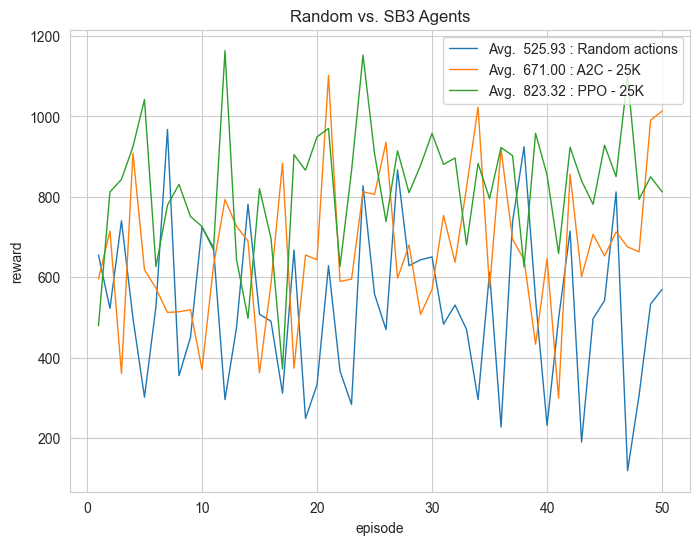

In [11]:

data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:

    if key == 'x': continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. SB3 Agents')
plt.legend()
plt.show()